# Лабораторная работа № 3 по дисциплине "Системы искусственного интеллекта"

## Задание лабораторной работы
0. Датасет:
    - Датасет [про обучение студентов](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)
1. Получите и визуализируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили).
2. Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и нормировка.
3. Разделите данные на обучающий и тестовый наборы данных.
4. Реализуйте линейную регрессию с использованием метода наименьших квадратов без использования сторонних библиотек, кроме NumPy и Pandas (для использования коэффициентов использовать библиотеки тоже нельзя). Использовать минимизацию суммы квадратов разностей между фактическими и предсказанными значениями для нахождения оптимальных коэффициентов.
5. Постройте **три модели** с различными наборами признаков. Для каждой модели проведите оценку производительности, используя метрику коэффициент детерминации, чтобы измерить, насколько хорошо модель соответствует данным.
6. Сравните результаты трех моделей и сделайте выводы о том, какие признаки работают лучше всего для каждой модели.
7. Бонусное задание
    - Ввести синтетический признак при построении модели

## Выполнение лабораторной работы
### 0. Установка и импорт библиотек, загрузка датасета

Сначала установим библиотеки, если они уже не установлены.

In [1]:
import math
!pip install numpy pandas matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Загрузим датасет и выведем основную статистику по нему и 5 первых строк:

In [3]:
data = pd.read_csv('Student_Performance.csv')
print(data.describe())
data.head()

       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.000000   
50%         5.000000        69.000000      7.000000   
75%         7.000000        85.000000      8.000000   
max         9.000000        99.000000      9.000000   

       Sample Question Papers Practiced  Performance Index  
count                      10000.000000       10000.000000  
mean                           4.583300          55.224800  
std                            2.867348          19.212558  
min                            0.000000          10.000000  
25%                            2.000000          40.000000  
50%                            5.000000          55.000000  
75%                            7.000000          71.000000  
max             

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


### 1. Визуализация статистики

Визуализируем эту статистику:

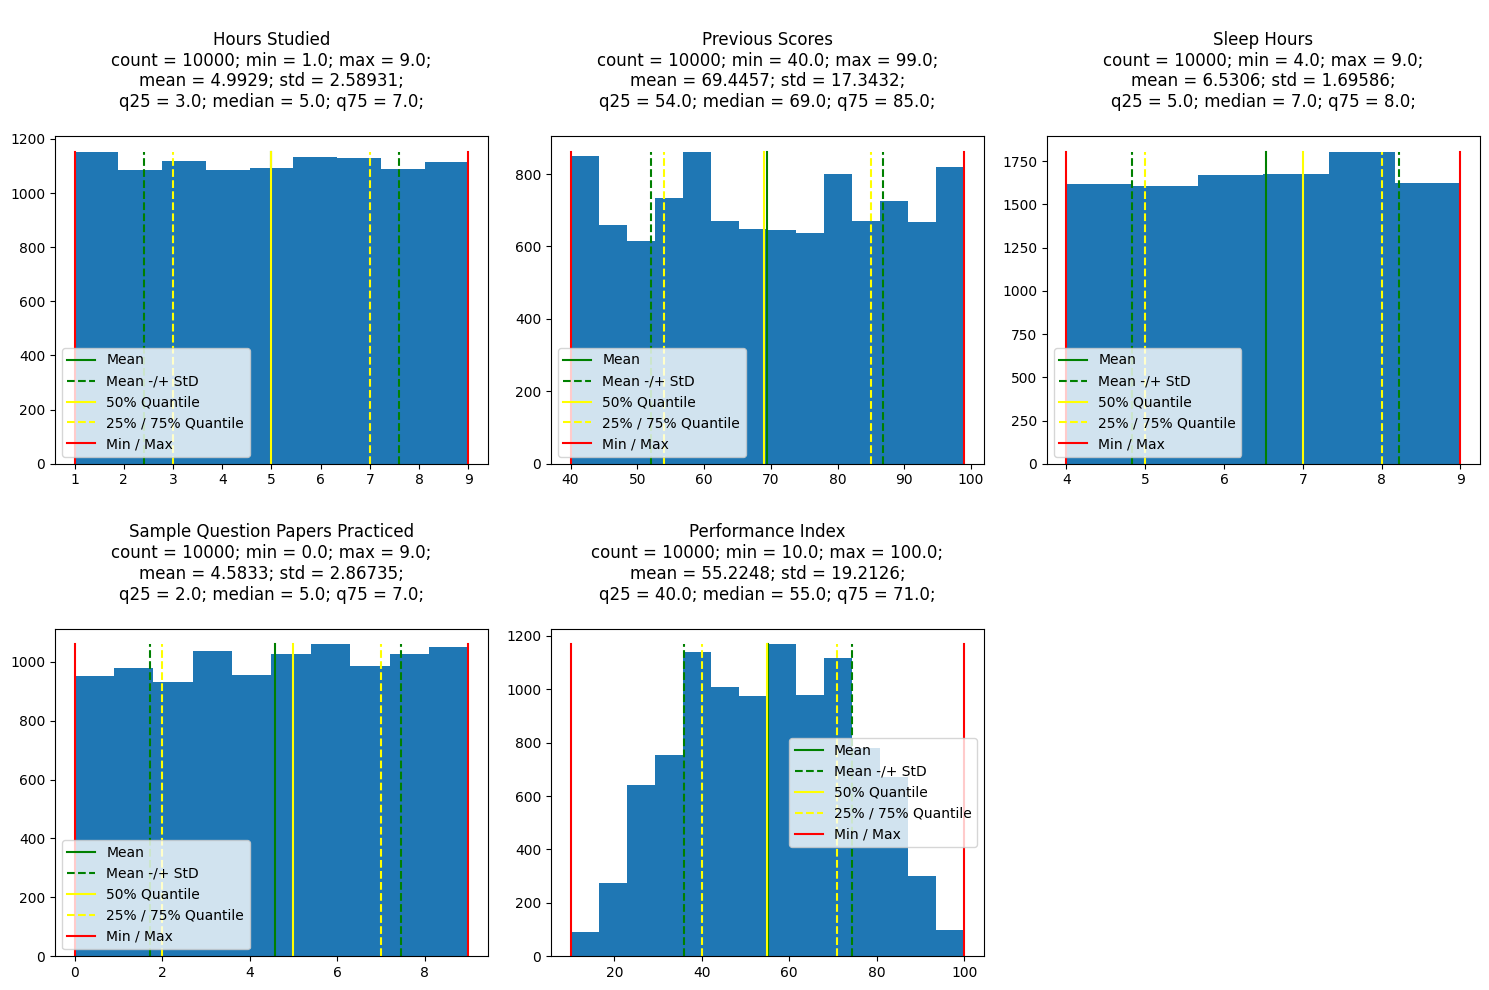

In [4]:
# Правило Стёрджиса для выбора оптимального количества интервалов в гистограмме 
def sturges(n):
    return int(1 + np.floor(np.log2(n)))

fig = plt.figure(figsize=(15, 10))

desc = data.describe()

non_numeric_column_count = 0

for i, col in enumerate(desc.columns):
    if data[col].dtype == 'object':
        non_numeric_column_count += 1
        continue
    
    ax = fig.add_subplot(2, 3, i + 1 - non_numeric_column_count)
    
    bin_count = min(sturges(len(data[col])), len(data[col].unique()))
    
    hist = ax.hist(data[col], bins=bin_count)
    
    count = int(desc[col]['count'])
    mean = desc[col]['mean']
    std = desc[col]['std']
    min_val = desc[col]['min']
    max_val = desc[col]['max']
    q25 = desc[col]['25%']
    median = desc[col]['50%']
    q75 = desc[col]['75%']
    
    line_mean = ax.plot([mean, mean], [0, np.max(hist[0])], color='green', label='Mean')
    line_mean_minus_std = ax.plot([mean - std, mean - std], [0, np.max(hist[0])],
                                  color='green', linestyle='dashed', label='Mean -/+ StD ')
    line_mean_plus_std = ax.plot([mean + std, mean + std], [0, np.max(hist[0])],
                                 color='green', linestyle='dashed')
    line_median = ax.plot([median, median], [0, np.max(hist[0])], 
                          color='yellow', label='50% Quantile')
    line_q25 = ax.plot([q25, q25], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed', label='25% / 75% Quantile')
    line_q75 = ax.plot([q75, q75], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed') 
    line_min = ax.plot([min_val, min_val], [0, np.max(hist[0])], color='red', label='Min / Max')
    line_max = ax.plot([max_val, max_val], [0, np.max(hist[0])], color='red')
    
    ax.set_title(
f"""
{col}
count = {count}; min = {min_val:.6}; max = {max_val:.6};
mean = {mean:.6}; std = {std:.6};
q25 = {q25:.6}; median = {median:.6}; q75 = {q75:.6};
"""
    )
    ax.legend()
    ax.plot()
    
    
fig.tight_layout()
plt.show()

### 2. Предварительная обработка данных
Обработка отсутствующих значений:

In [5]:
data = data.dropna(axis='rows')  # Drop rows with missing values

Кодирование категориальных признаков:
- Категориальным является только признак `Extracurricular Activities` (принимает значения `Yes`, `No`). Все остальные -- числовые.

Будем кодировать этот признак числом (`'No' : 0, 'Yes' : 1`).

In [6]:
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'No': 0, 'Yes': 1})
data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,1,4,2,23.0
9996,7,64,1,8,5,58.0
9997,6,83,1,8,5,74.0
9998,9,97,1,7,0,95.0


Нормализуем данные.
Нормализацию осуществляем по принципу:
$$
x_i' = \cfrac{x_i - \bar{X}}{\sigma},
$$
где $\bar X$ -- выборочное среднее, $\sigma$ -- стандартное отклонение.

In [7]:
norm_data = (data - data.mean()) / data.std()
norm_data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,0.775149,1.704090,1.010404,1.456132,-1.249691,1.862074
1,-0.383461,0.723876,-0.989604,-1.492220,-0.900937,0.508792
2,1.161352,-1.063573,1.010404,0.276791,-0.900937,-0.532194
3,0.002742,-1.005913,1.010404,-0.902549,-0.900937,-1.000637
4,0.775149,0.320259,-0.989604,0.866462,0.145326,0.560842
...,...,...,...,...,...,...
9995,-1.542072,-1.178892,1.010404,-1.492220,-0.900937,-1.677278
9996,0.775149,-0.313997,1.010404,0.866462,0.145326,0.144447
9997,0.388945,0.781536,1.010404,0.866462,0.145326,0.977236
9998,1.547556,1.588771,1.010404,0.276791,-1.598446,2.070271


In [8]:
norm_data.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,9.805490e-17,-1.247003e-16,1.776357e-17,1.612932e-16,-1.357137e-16,-9.734435e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.542072e+00,-1.697829e+00,-9.896040e-01,-1.492220e+00,-1.598446e+00,-2.353919e+00
25%,-7.696649e-01,-8.905936e-01,-9.896040e-01,-9.025493e-01,-9.009371e-01,-7.924400e-01
50%,2.742045e-03,-2.569890e-02,-9.896040e-01,2.767912e-01,1.453259e-01,-1.170068e-02
75%,7.751490e-01,8.968554e-01,1.010404e+00,8.664615e-01,8.428346e-01,8.210880e-01
max,1.547556e+00,1.704090e+00,1.010404e+00,1.456132e+00,1.540343e+00,2.330517e+00


### 3. Разбиение данных на обучающий и тестовый набор данных

Разделим данные в соотношении 80:20 (80% -- обучающий набор данных, 20% -- тестовый набор данных).

In [9]:
TRAIN_DATA_PERCENTAGE = 0.8
assert 0 < TRAIN_DATA_PERCENTAGE < 1

In [10]:
norm_data = norm_data.sample(frac=1).reset_index(drop=True)  # Shuffle data

train_size = int(len(norm_data) * TRAIN_DATA_PERCENTAGE)

train_data, test_data = norm_data[:train_size], norm_data[train_size:]

### 4. Линейная регрессия с помощью МНК
#### 4.0. Функции для построения линейной регрессии и оценки производительности

Модель линейной регрессии предполагает, что зависимость между зависимой переменной $y$ и независимыми переменными $x_1$, $x_2$, ..., $x_k$ --- линейная. Иными словами,

$$
y = \beta_1 + \beta_2 x_1 + \beta_3 x_2 + \dots + \beta_{k+1} x_k + \varepsilon,
$$

где $\beta_i$ -- параметры (коэффициенты) модели; $x_i$ -- регрессоры (факторы) модели; $\varepsilon$ -- случайная ошибка модели.

Для нахождения коэффициентов линейной регрессии зачастую используется метод наименьших квадратов (МНК). Его суть состоит в том, чтобы найти такой вектор коэффициентов $\hat{\beta_t}$, чтобы сумма квадратов отклонений (ошибок, или остатков регрессии) $e_t$ будет минимальной:
$$
\hat{\beta}=\arg\min\limits_{\beta} RSS(\beta),
$$
где $RSS$ (сумма квадратов остатков) определяется как:
$$
RSS = e^T e = \sum\limits_{i=1}^{n} e_i^2 = \sum\limits_{i=1}^{n}(y_i - f(x_i, \beta))^2,
$$
где $f(x_i, \beta)$ -- функция (в данном случае -- линейная), аппроксимирующая $y_i$ и известная с точностью до некоторых неизвестных параметров $\beta$.

В матричной форме оценку этих коэффициентов можно выразить следующим образом:

$$
\hat{\beta} = (X^T X)^{-1}X^T Y,
$$
где $Y$ -- вектор наблюдаемых значений зависимой переменной, $X$ -- матрица $n\times k$ ($n$ -- число наблюдений; $k$ -- число независимых переменных; в каждом столбце стоят значения одной переменной по всем наблюдениям; каждая строка --- одно наблюдение).

Чтобы получить модель с константой $\hat{\beta_0}$, задающей смещение по $y$ (intercept), нужно приписать к матрице $X$ слева столбец из единиц. В таком случае линия (или гиперплоскость) регрессии будет проходить не через начало координат, а через "центр тяжести" данных.

In [11]:
def linear_regression(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.linalg.inv(x.T @ x) @ x.T @ y

В таком случае коэффициенты будут предсказываться следующим образом:
$$
\hat{y} = \hat{\beta_0} + \sum_{i=1}^{k}\hat{\beta}_{i+1}x_{i},
$$
или, в матричной форме:
$$
\hat{y} = X\hat{\beta}.
$$

In [12]:
def predict(x: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return x @ beta

Важной характеристикой модели является коэффициент детерминации $R^2$, характеризующий, насколько дисперсия зависимой переменной "объяснена", т. е. доля дисперсии зависимой переменной, объясняемая независимыми переменными. Чем меньше дисперсия случайной ошибки, тем ближе коэффициент к 1.

В случае линейной регрессии вычисляется по формуле:

$$
R^2 = 1 - \cfrac{RSS}{TSS}.
$$

Здесь $RSS$ -- сумма квадратов остатков (Residual Sum of Squares):
$$
RSS = \sum_{i=1}^n(Y_i-\hat{Y}_i)^2 = (Y-X\hat{\beta})^T(Y-X\hat{\beta})
$$

Здесь $TSS$ -- общая сумма квадратов (Total Sum of Squares), вычисляемая по формуле:
$$
TSS = \sum_{i=1}^n(Y_i-\bar{Y})^2,
$$

где $\bar{Y}$ -- выборочное среднее зависимой переменной.

In [13]:
def calculate_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    rss = np.sum(np.square(y_true - y_pred))
    tss = np.sum(np.square(y_true - y_true.mean()))
    r2 = 1 - rss / tss
    return r2

Напишем функцию, которая строит линейную регрессию, а затем считает $R^2$ и на обучающем, и на тестовом наборе.

In [14]:
def calculate_coeffs_and_r2_score(train_data: pd.DataFrame,
                       test_data: pd.DataFrame,
                       dependent_variable: str,
                       variables_to_exclude: list[str] = (),
                       variables_to_keep: list[str] = ()) -> dict[str, object]:
    assert not variables_to_keep or not variables_to_exclude, 'Cannot specify both variables to exclude and variables to keep'
    
    if variables_to_keep:
        # If variables_to_keep is provided, only keep these features
        x_train = train_data[list(variables_to_keep)]
        x_test = test_data[list(variables_to_keep)]
    else:
        # Otherwise drop the excluded variables and the dependent variable
        x_train = train_data.drop([dependent_variable] + list(variables_to_exclude), axis=1)
        x_test = test_data.drop([dependent_variable] + list(variables_to_exclude), axis=1)
    
    # Add intercept (column of ones) to both train and test sets
    x_train = np.column_stack((np.ones(shape=x_train.shape[0]), x_train.values))
    x_test = np.column_stack((np.ones(shape=x_test.shape[0]), x_test.values))
    y_train = train_data[dependent_variable]
    y_test = test_data[dependent_variable]
    
    coeffs = linear_regression(x_train, y_train)
    
    y_pred_train = predict(x_train, coeffs)
    r2_train = calculate_r2(y_train, y_pred_train)
    
    y_pred_test = predict(x_test, coeffs)
    r2_test = calculate_r2(y_test, y_pred_test)
    
    return {
        'coeffs': coeffs,
        'r2_train': r2_train,
        'r2_test': r2_test
    }

#### 4.1. Полный набор признаков
Будем оценивать зависимость индекса успеваемости (`Performance Index`) от всех прочих признаков.

In [15]:
result1 = calculate_coeffs_and_r2_score(train_data, test_data, 'Performance Index')

#### 4.2. Неполный набор признаков
Исключим из модели признаки "часы сна" (`Sleep Hours`) и "внеучебная деятельность" (`Extracurricular Activities`), ведь кому нужен этот ваш сон и смена деятельности? В остальном выполняем те же самые действия, что и в предыдущих примерах.

In [16]:
result2 = calculate_coeffs_and_r2_score(
    train_data, test_data, 'Performance Index',
    variables_to_exclude=['Sleep Hours', 'Extracurricular Activities'],
)

#### 4.3. Неполный набор признаков (С твистом)
Впрочем, я поменял своё мнение: "часы сна" (Sleep Hours) и "внеучебная деятельность" (Extracurricular Activities) действительно очень важны ~~(В дальнейшем мы поймём, что это сарказм)~~. Теперь оставим только эти признаки.

In [17]:
result3 = calculate_coeffs_and_r2_score(
    train_data, test_data, 'Performance Index',
    variables_to_keep=['Sleep Hours', 'Extracurricular Activities'],
)

#### 4.4. Все наборы признаков
Ха. Хаха. Хахаха.
Вам меня не остановить.

In [18]:
from itertools import combinations
from math import comb

desc = norm_data.describe()
desc_without_dependent = desc.drop('Performance Index', axis='columns')

def r2_test_for_all_combinations():
    n = desc_without_dependent.columns.size
    combs_count = sum((comb(n, k) for k in range(1, n + 1)))
    
    assert combs_count <= 100, f'Too many possible combinations ({combs_count} > 100) for {n} variables'
    
    results: list[(float, list[str])] = []
    
    for i in range(1, desc_without_dependent.columns.size + 1):
        for combination in combinations(desc_without_dependent.columns, i):
            combination = list(combination)
            
            r2_test = calculate_coeffs_and_r2_score(
                train_data,
                test_data,
                'Performance Index',
                variables_to_keep=combination
            )['r2_test']
            results.append((r2_test, combination))
            
    
    results.sort(key=lambda result: -result[0])
    
    for result in results:
        print(f'{result[0]:.6f} : {result[1]}')

r2_test_for_all_combinations()

0.988630 : ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
0.988223 : ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
0.987784 : ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours']
0.987364 : ['Hours Studied', 'Previous Scores', 'Sleep Hours']
0.986853 : ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sample Question Papers Practiced']
0.986476 : ['Hours Studied', 'Previous Scores', 'Sample Question Papers Practiced']
0.985967 : ['Hours Studied', 'Previous Scores', 'Extracurricular Activities']
0.985577 : ['Hours Studied', 'Previous Scores']
0.845871 : ['Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
0.845435 : ['Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
0.844121 : ['Previous Scores', 'Extracurricular Activities', 'Sample Question Papers Practiced']
0

#### 4.5. Синтетический признак
Введём синтетический признак: `Speed Performance` (производительность по скорости), который будет рассчитываться как:
$$
\text{Speed Performance} = \left\{\begin{matrix}
    \cfrac{\text{Sample Question Papers Practiced}}{\text{Hours Studied}}, & \text{Hours Studied} > 0, \\
    \cfrac{\text{Sample Question Papers Practiced}}{\varepsilon}, & \text{else},
\end{matrix}\right.
$$
где $\varepsilon$ -- маленькое значение.

Создаём копию датасета с синтетическим признаком:

In [19]:
EPSILON = 1e-6

In [20]:
augm_data = data.copy()
augm_data['Speed Performance'] = augm_data['Sample Question Papers Practiced'] / np.where(
    augm_data['Hours Studied'] > 0, augm_data['Hours Studied'], EPSILON
)
augm_data.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Speed Performance
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800,1.443633
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558,1.720765
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000,0.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000,0.428571
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000,1.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000,1.666667
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000,9.000000


Нормируем этот датасет:

In [21]:
augm_norm_data = (augm_data - augm_data.mean()) / augm_data.std()
augm_norm_data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Speed Performance
0,0.775149,1.704090,1.010404,1.456132,-1.249691,1.862074,-0.755929
1,-0.383461,0.723876,-0.989604,-1.492220,-0.900937,0.508792,-0.548380
2,1.161352,-1.063573,1.010404,0.276791,-0.900937,-0.532194,-0.693664
3,0.002742,-1.005913,1.010404,-0.902549,-0.900937,-1.000637,-0.606494
4,0.775149,0.320259,-0.989604,0.866462,0.145326,0.560842,-0.423851
...,...,...,...,...,...,...,...
9995,-1.542072,-1.178892,1.010404,-1.492220,-0.900937,-1.677278,0.323325
9996,0.775149,-0.313997,1.010404,0.866462,0.145326,0.144447,-0.423851
9997,0.388945,0.781536,1.010404,0.866462,0.145326,0.977236,-0.354668
9998,1.547556,1.588771,1.010404,0.276791,-1.598446,2.070271,-0.838949


Разделяем его:

In [22]:
augm_train_data = augm_norm_data[:train_size]
augm_test_data = augm_norm_data[train_size:]

Строим линейную регрессию и вычисляем $R^2$:

In [23]:
result4 = calculate_coeffs_and_r2_score(augm_train_data, augm_test_data, 'Performance Index')

Оцениваем, в каком случае $R^2$ получился выше всего:

In [24]:
results = [
    (result1['r2_test'], 'All variables'),
    (result2['r2_test'], 'All variables, excluding "Sleep Hours" and "Extracurricular Activities'),
    (result3['r2_test'], 'Only "Sleep Hours" and "Extracurricular Activities"'),
    (result4['r2_test'], 'All variables, plus "Speed Performance"')
]

results.sort(key=lambda result: -result[0])
for result in results:
    print(f'{result[0]:.6f} : {result[1]}')

0.988630 : All variables
0.988344 : All variables, plus "Speed Performance"
0.986476 : All variables, excluding "Sleep Hours" and "Extracurricular Activities
0.003986 : Only "Sleep Hours" and "Extracurricular Activities"


Добавление синтетического признака немного снизило предсказательную способность модели ($R^2$), что может означать, что этот признак не добавил значимой информации, или даже создал некоторую избыточность в модели.